# 1. Imports & Configuration

In [42]:
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

pd.set_option("display.max_colwidth", 200)


# 2. Loading in the dataset

In [43]:
file_path = Path("../Data/Raw/Uitgebreide_VKM_dataset.csv")
df = pd.read_csv(file_path, low_memory=False)
df.head()

,id,name,shortdescription,description,content,studycredit,location,contact_id,level,learningoutcomes,Rood,Groen,Blauw,Geel,module_tags,interests_match_score,popularity_score,estimated_difficulty,available_spots,start_date
0,159,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen.",In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,15,Den Bosch,58,NLQF5,A. Je beantwoordt vragen in een meerkeuze kennistoets waarin je laat zien dat je de basis van de psychologie kunt reproduceren en begrijpt. Je laat zien dat je gedrag van individuen en groepen in ...,4.0,2.0,1.0,5.0,"['brein', 'gedragsbeinvloeding', 'ontwikkelingspsychologie', 'gespreksvoering', 'en', 'ontwikkelingsfasen']",0.54,319,1,79,2025-12-24
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, verpleegkunde","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...",15,Den Bosch,58,NLQF5,De student toont professioneel gedrag conform de beroepscode bij laagcomplexe zorgvragers en collega's in de zorgsetting.,5.0,3.0,1.0,1.0,"['internationaal', 'persoonlijke', 'ontwikkeling', 'verpleegkunde']",0.92,172,5,56,2025-12-20
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...",15,Den Bosch,59,NLQF5,"De student past pro actieve zorgplanning toe binnen het proces van het klinisch redeneren bij casuïstiek over zorgvragers, multidisciplinair, in de ziekenhuissetting.",NaN,NaN,NaN,NaN,"['proactieve', 'zorgplanning', 'cocreatie', 'ziekenhuis']",0.78,217,5,55,2025-09-23
3,162,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het palliatieve proces uit bij hoog/middencomplexe zorgvragers in de zorgsetting op basis van het proces van palliatie...,NaN,NaN,NaN,NaN,"['rouw', 'verlies', 'palliatieve', 'zorg', 'redeneren', 'trauma', 'culturele', 'diversiteit']",0.69,454,1,54,2025-10-25
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het verpleegkundige proces uit bij hoog/middencomplexe zorgvragers in de actue en

# 3. Overview dataset and data quality

In this section we explore the structure, data types, and overall data quality of the dataset. We look at the shape, column types, missing values, and basic numeric statistics.


In [44]:
# Basic info
print("Shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)

# Missing values
miss = df.isnull().mean() * 100
print("\nMissing %:")
print(miss.sort_values(ascending=False))

# Numeric summary
num = df.select_dtypes(include=[np.number])
print("\nNumeric summary:")
print(num.describe().T)

# Categorical summary for selected columns
for col in ['name', 'shortdescription', 'description', 'content', 'location', 'level', 'learningoutcomes', 'module_tags', 'start_date']:
    print(f"\n--- {col} ---")
    vc = df[col].value_counts(dropna=False).head(10)
    print("Top values:\n", vc)
    print("Unique (non-null):", df[col].nunique(dropna=True))

# Date parsing for 'start_date' column
parsed_dates = pd.to_datetime(df['start_date'], errors='coerce')
print("\nstart_date parsing:")
print("Nulls after parsing:", parsed_dates.isna().sum())
print("Top parsed dates:")
print(parsed_dates.value_counts().head())

Shape: (211, 20)

Columns and dtypes:
id                         int64
name                      object
shortdescription          object
description               object
content                   object
studycredit                int64
location                  object
contact_id                 int64
level                     object
learningoutcomes          object
Rood                     float64
Groen                    float64
Blauw                    float64
Geel                     float64
module_tags               object
interests_match_score    float64
popularity_score           int64
estimated_difficulty       int64
available_spots            int64
start_date                object
dtype: object

Missing %:
Blauw                    99.052133
Geel                     99.052133
Groen                    99.052133
Rood                     99.052133
shortdescription          9.478673
learningoutcomes          2.369668
id                        0.000000
name                      0.000

What we found from this:
- Most columns are of type "Object" containing textual data. This is also the sort of data most useful for a content-based recommender systen we plan making. 
- The color coded columns only have 2 rows containing data. Short descritpion and learning outcomes have some missing values we'll have to look into deeper during data cleaning.
- Popularity Score goes from 10 to 500. Dificulty goes from 1 to 5. Interest scores seems to go from 0 to 1. This could all be normalized to a value from 0.1 for consistency...
- There are some rows containing duplicate data --> Duplicates need to be removed during data cleaning.
- Bepaalde tags zijn leeg of zijn gevuld met 'ntb'

# 4. Numeric Values


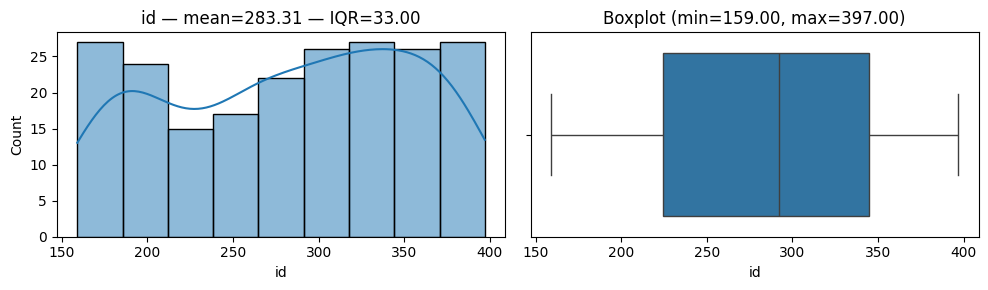

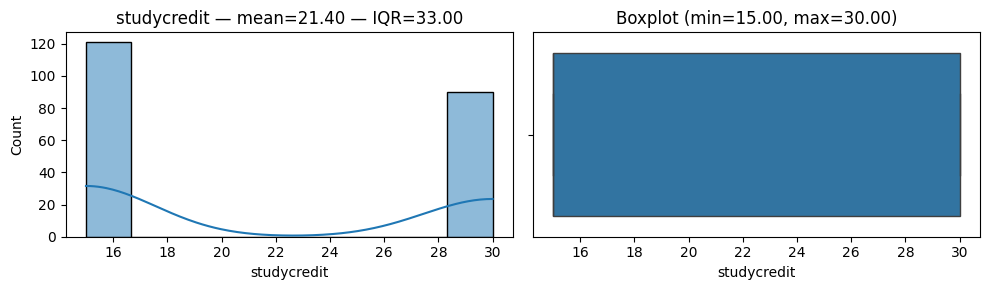

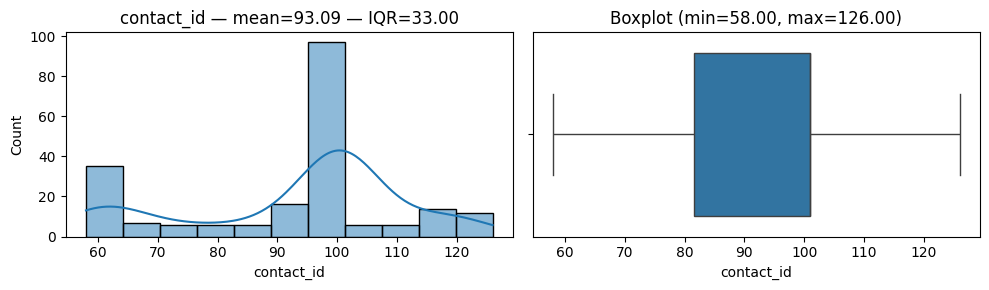

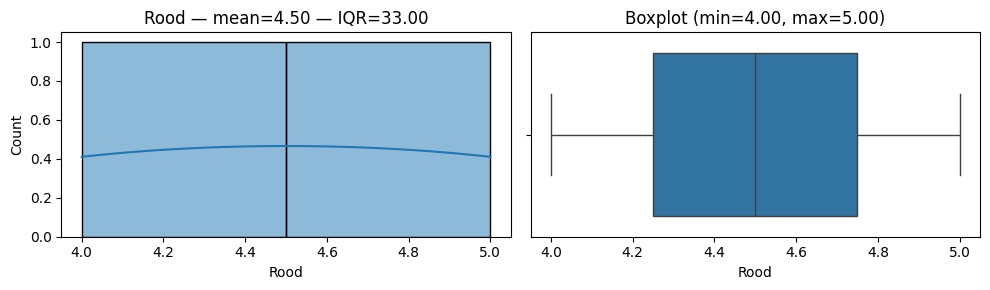

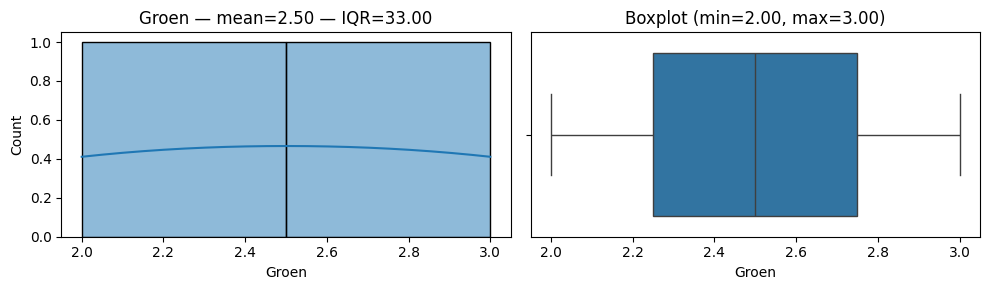

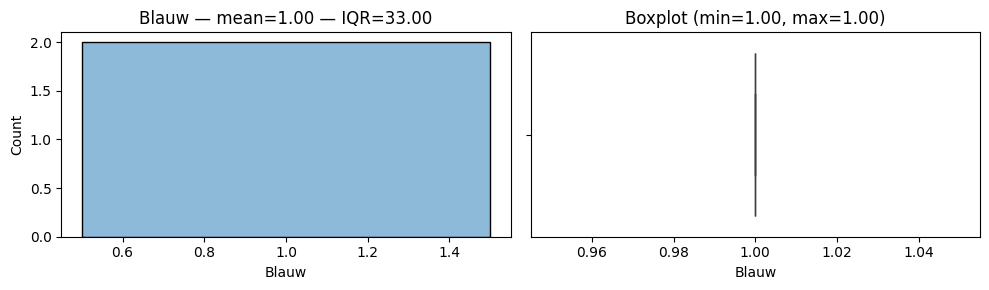

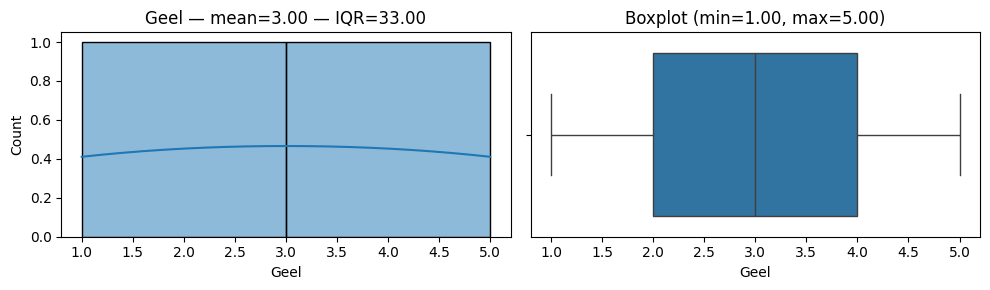

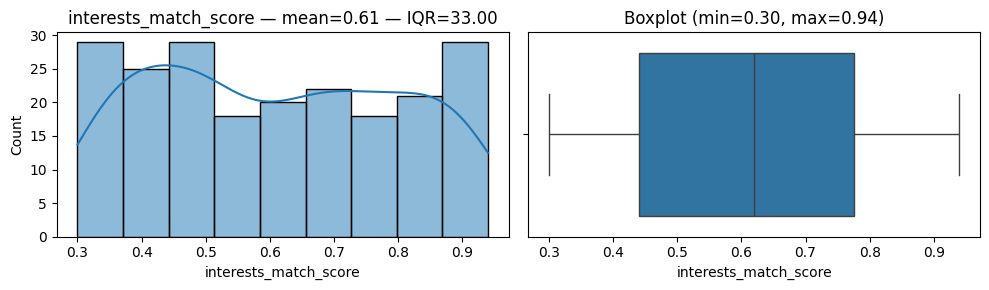

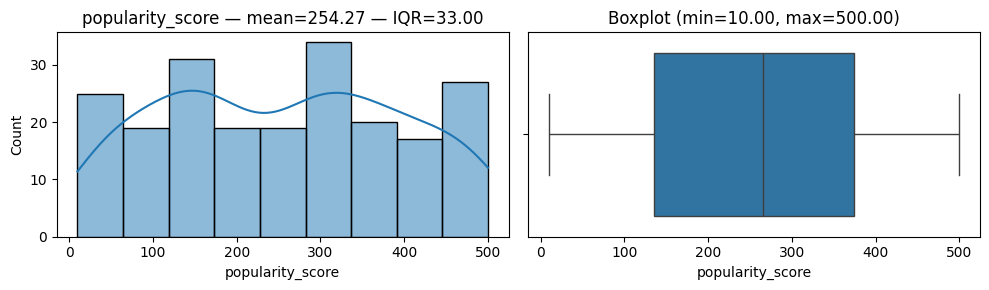

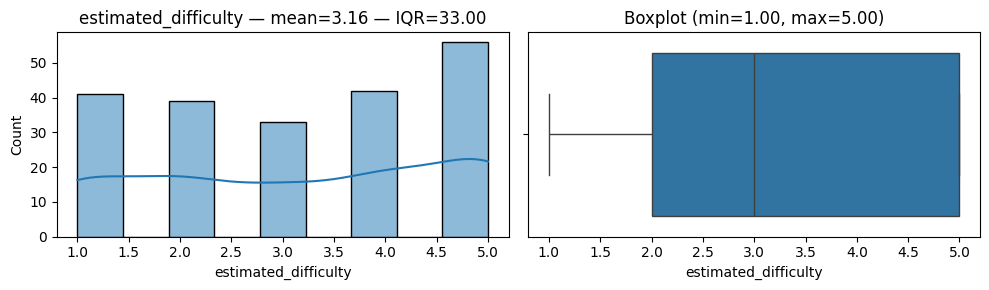

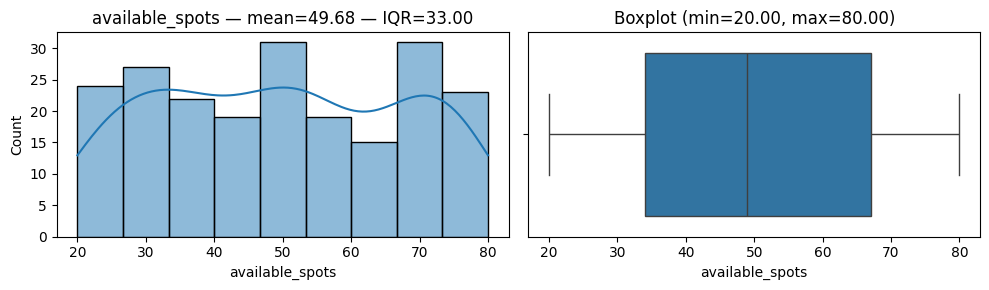

In [79]:
from IPython.display import HTML, display
import html as _html

num = df.select_dtypes(include=[np.number]).copy()
summary = []

for col in num.columns:
    col_s = num[col].dropna()
    mean = col_s.mean()
    min_val = col_s.min() if len(col_s) > 0 else np.nan
    max_val = col_s.max() if len(col_s) > 0 else np.nan

    # Plots
    if len(col_s) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.histplot(col_s, ax=axes[0], kde=True)
        axes[0].set_title(f"{col} — mean={mean:.2f} — IQR={iqr:.2f}")
        sns.boxplot(x=col_s, ax=axes[1])
        axes[1].set_title(f"Boxplot (min={min_val:.2f}, max={max_val:.2f})")
        plt.tight_layout()
        plt.show()


What we found (besides the findings already mentioned earlier)
- Studycredit exists only in 15 or 30 points
- One contactId stands out for the rest 

Other numerical analysis doesn't really show anything standing out in particular...

# 5. Categorical Values

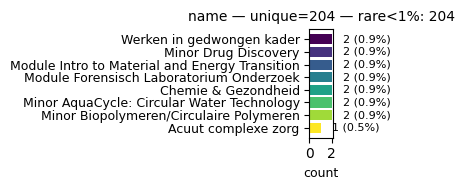

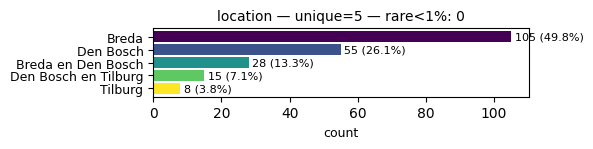

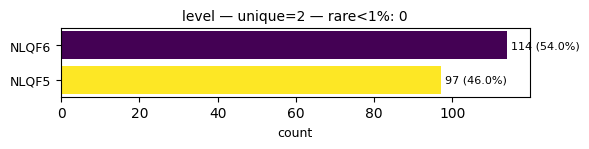

C:\Users\woute\AppData\Local\Temp\ipykernel_21888\3663421351.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


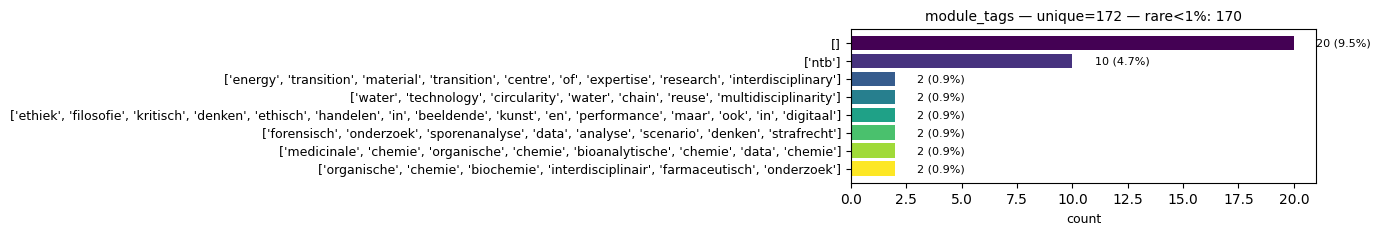

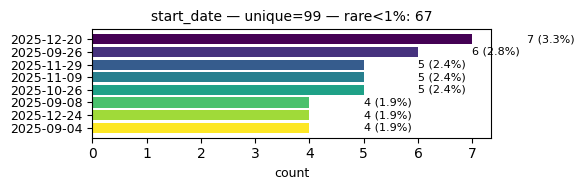

In [74]:
# Parameters
exclude_text_cols = ['shortdescription', 'description', 'content', 'learningoutcomes']
top_n = 8             # fewer bars for compactness
rare_threshold = 0.01 # <1% wordt 'rare' (fraction)

# Find categorical columns (exclude long free-text columns)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in exclude_text_cols]

total = len(df)

for col in cat_cols:
    vc = df[col].fillna('<<NA>>').value_counts(dropna=False)
    vc_prop = vc / total

    # compact top-N
    topn = vc.head(top_n)
    rare_count = int((vc_prop < rare_threshold).sum())

    # compact figure
    fig, ax = plt.subplots(figsize=(6, max(1.6, 0.25 * len(topn))))
    colors = plt.cm.viridis(np.linspace(0, 1, len(topn)))

    y = list(range(len(topn)))
    ax.barh(y, topn.values, color=colors)
    ax.set_yticks(y)
    ax.set_yticklabels([str(x) for x in topn.index], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('count', fontsize=9)
    ax.set_title(f'{col} — unique={vc.size} — rare<{int(rare_threshold*100)}%: {rare_count}', fontsize=10)

    # annotate counts and percentages on the bars (compact)
    for i, (val, cnt) in enumerate(zip(topn.index, topn.values)):
        pct = vc_prop.get(val, 0)
        # small offset, use max(1, 1% of largest) to avoid overlap
        xoff = max(1, int(0.01 * max(topn.values)))
        ax.text(cnt + xoff, i, f'{int(cnt)} ({pct:.1%})', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()


# 6. Correlation heatmap


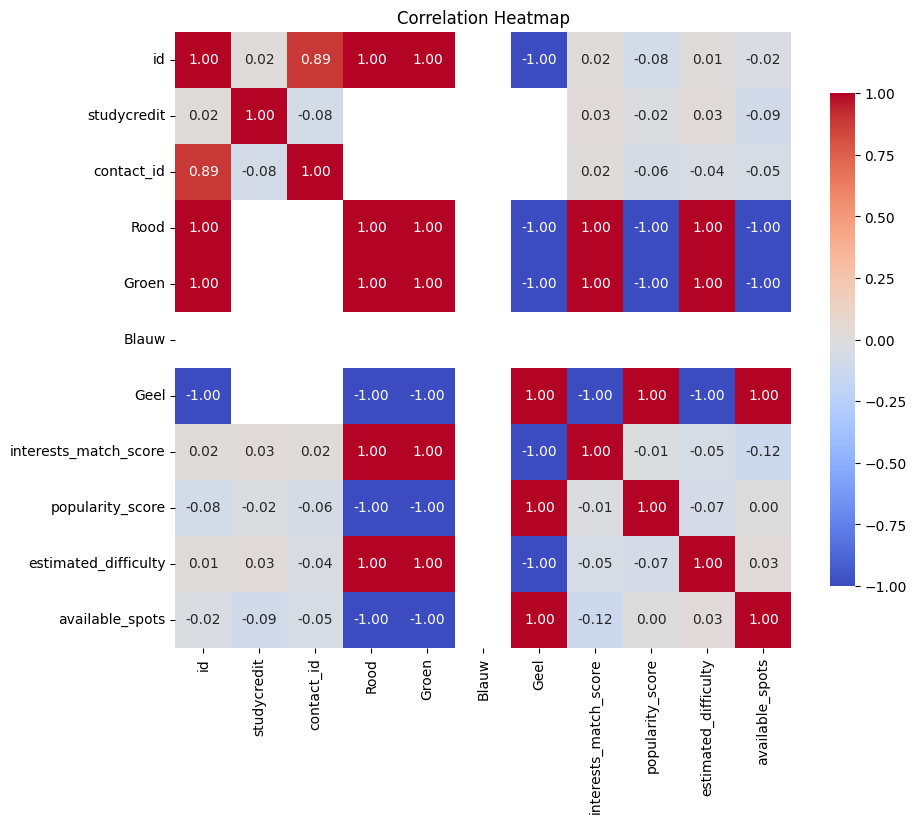

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap")
plt.show()

Based on our exploration of the dataset, we cannot build a traditional prediction model. The available features show no significant correlations with the target variable, and the data does not provide meaningful input-output relationships that would allow a supervised learning model to perform well.

Additionally, the target itself represents content, which is not easily predicted using standard regression or classification techniques.

Because of this, a recommendation system is a much more suitable solution.
Instead of predicting a specific value, a recommender focuses on similarity between items or user preferences, which matches the structure of our dataset.

Therefore, we will proceed with building a Hybrid Content-Based Recommender system, which combines content-based filtering with collaborative filtering techniques to provide personalized recommendations. This approach leverages both the attributes of the items and user interaction data to enhance recommendation accuracy. This method is well-suited for our dataset and the goals of our project. 

But first, we are going to clean the dataset. This is done in the next notebook.